In [1]:
from GvaDataset import GvaDataset
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms 

transform = transforms.Compose([
    transforms.Resize((1024, 512))
])

images_path = "/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/data/_Original"
labels_path = "/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/data/labels"
dataset = GvaDataset(images_path, labels_path, transform=transform)

total_size = len(dataset)
train_size = int(total_size * 0.8)  # 80% for training
test_size = total_size - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
img, lab, _ = train_dataset[3]
print(img.shape)
print(lab.shape)

torch.Size([3, 1024, 512])
torch.Size([1024, 512])


In [2]:
from models.unet import UNet
from experiment import Experiment
from losses import dice_loss
import torch.optim as optim
import torch.nn as nn
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()
experiment = Experiment(model, criterion, optimizer, device)

In [3]:
experiment.train(train_loader=train_loader, validation_loader=test_loader, epochs=10)

Epoch 1/10:   0%|                                    | 0/1.0 [00:00<?, ?batch/s]/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/models/unet.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(self.conv(dec1))
Epoch 1/10:   0%|                                    | 0/1.0 [00:04<?, ?batch/s]


ValueError: Using a target size (torch.Size([4, 1024, 512])) that is different to the input size (torch.Size([4, 1, 1024, 512])) is deprecated. Please ensure they have the same size.

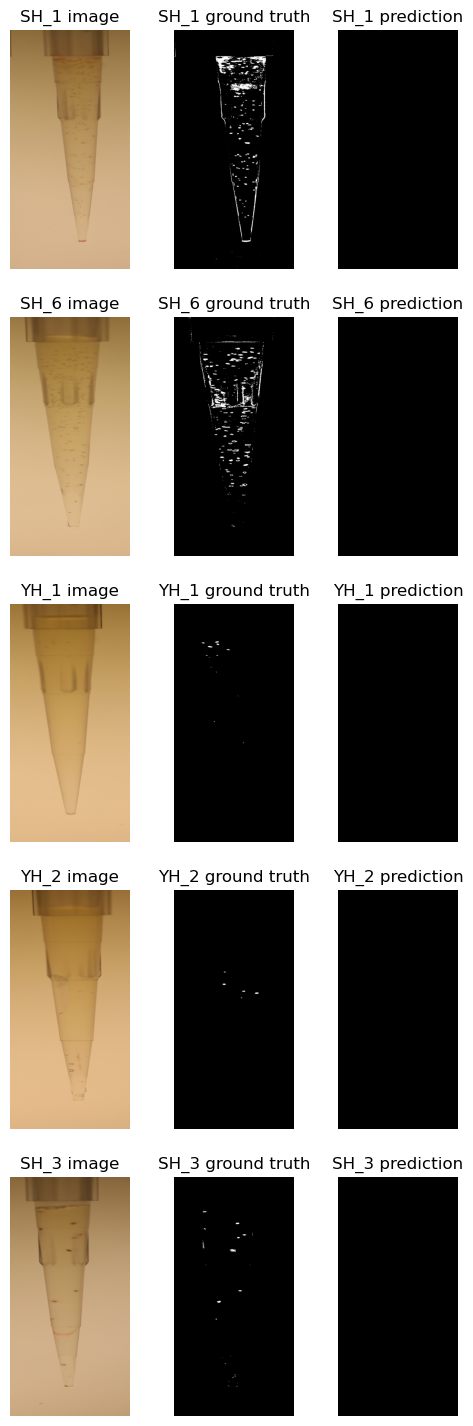

In [4]:
import matplotlib.pyplot as plt

with torch.no_grad():
    fig, ax = plt.subplots(5, 3, figsize=(6, 18))
    for i, data in enumerate(test_loader):
        img, label, file = data
        file = file[0]
        img = img.to(device)
        pred = model(img)
        pred = pred > 0.5
        
        img = img.to('cpu')
        img = img.squeeze()
        img = img.permute(1, 2, 0)

        label = label.squeeze()
            
        pred = pred.to('cpu')
        pred = pred.squeeze()
        
        ax[i, 0].imshow(img)
        ax[i, 0].axis('off')
        ax[i, 0].set_title(file + " image")
        ax[i, 1].imshow(label, cmap='gray')
        ax[i, 1].axis('off')
        ax[i, 1].set_title(file + " ground truth")
        ax[i, 2].imshow(pred, cmap='gray')
        ax[i, 2].axis('off')
        ax[i, 2].set_title(file + " prediction")        

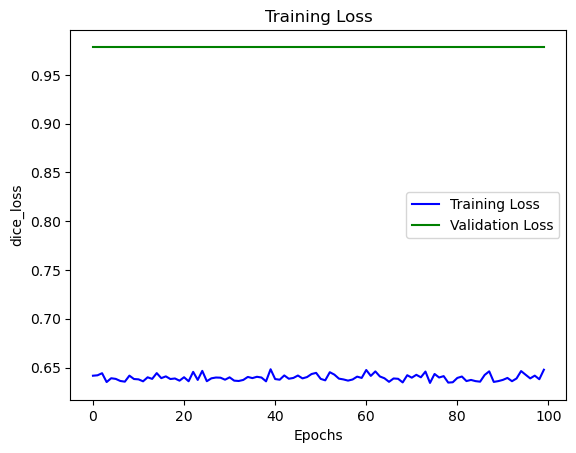

In [6]:
experiment.plot_loss()

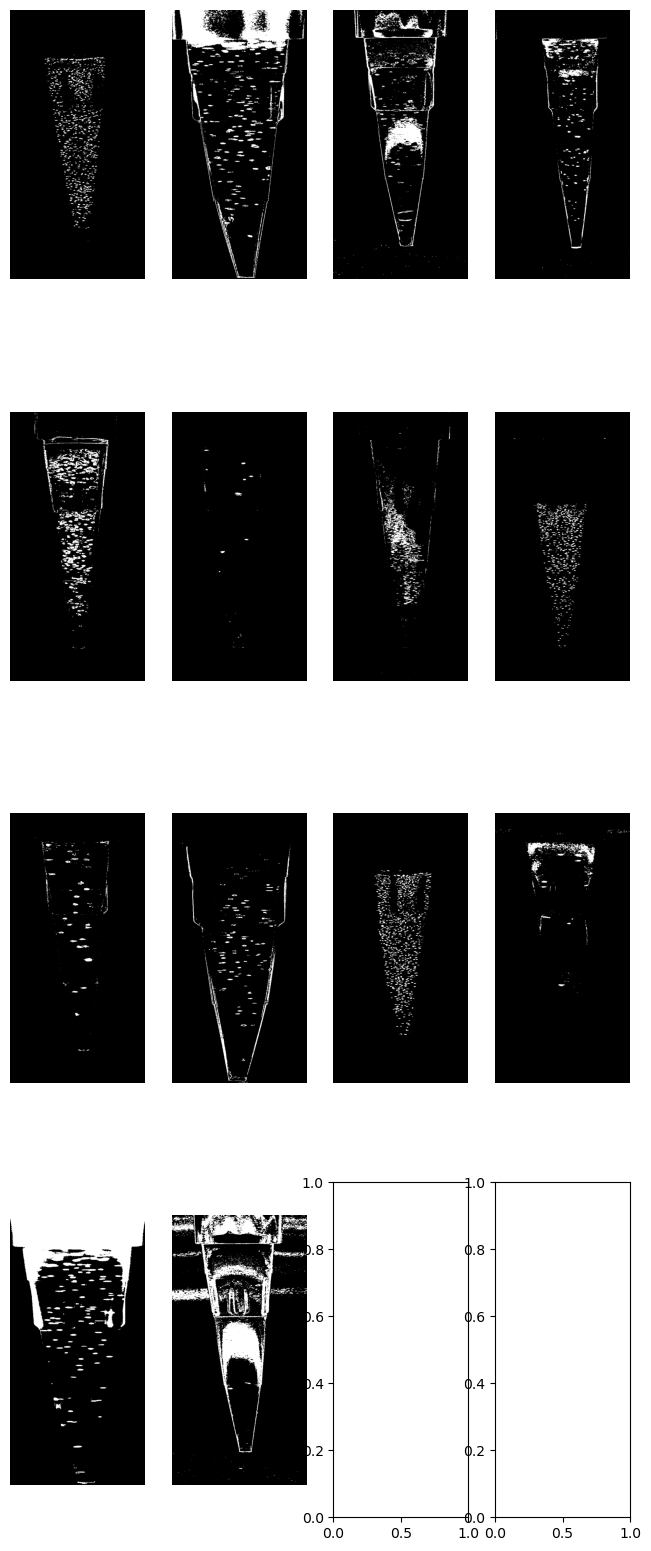

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(train_loader), 4, figsize=(8, 20))
for i, data in enumerate(train_loader):
    images, labels, _ = data
    for j in range(4):
        if images.shape[0] == j:
            break
        img = labels[j]

        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].axis('off')